In [489]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


In [681]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import requests
from urllib.error import HTTPError

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

%pylab inline
%matplotlib inline
matplotlib.style.use('fivethirtyeight')


ModuleNotFoundError: No module named 'researchpy'

### Data Schema Analysis

In [3]:
# importing of data
endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'
count = 1000
pages = 200

results = []
params = {'$limit': count, '$offset': 0}

for i in range(0, pages):
    
    try:
        r = requests.get(endpoint, params=params)
        results.append(r.json())
        params['$offset'] = count
        count += 1000
        
    except HTTPError as err:
        if err.response.status_code == '404':
            break
        else:
            print(err.response.status_code)

len(results)

200

In [4]:
outcome_df = pd.DataFrame()

for i in results:
    outcome_df = outcome_df.append(pd.io.json.json_normalize(i))

len(outcome_df)

98200

In [491]:
cats_df = outcome_df[outcome_df['animal_type'] == 'Cat'].reset_index()
del cats_df['index']

In [492]:
cats_df.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,36254,36254,36254,36254,36254,36254,36254,36254,20240,22577,36253,36254
unique,46,34628,1,91,258,4677,27350,27350,8435,17,8,5
top,2 months,A774102,Cat,Domestic Shorthair Mix,Brown Tabby,2016-04-15T00:00:00.000,2015-08-11T00:00:00.000,2015-08-11T00:00:00.000,Luna,Partner,Transfer,Spayed Female
freq,7153,7,36254,28926,5480,69,25,25,77,11322,16112,10869


In [493]:
cats_df.head(1)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 years,A791480,Cat,Domestic Shorthair Mix,White/Gray,2017-03-26T00:00:00.000,2019-04-11T15:29:00.000,2019-04-11T15:29:00.000,*Jamie,NaN,Adoption,Neutered Male


In [494]:
# remove if outcome is nan
cats_df = cats_df.dropna(subset=['outcome_type'])

### Clean Up

In [495]:
cats_df['count'] = 1

In [496]:
cats_df['sex_upon_outcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Female', 'Intact Male',
       'Unknown'], dtype=object)

In [497]:
cats_df['male'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 1, 0)
cats_df['female'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 0, 1)
cats_df['spayed_or_neutered'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 0, 1)
cats_df['intact'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 1, 0)

In [498]:
cats_df['age_upon_outcome'].head()

0    2 years
1    2 years
2    3 years
3     1 year
4    2 years
Name: age_upon_outcome, dtype: object

In [499]:
cats_df = cats_df[cats_df['age_upon_outcome'] != 'NULL']
cats_df['Periods'], cats_df['Period Range'] = cats_df['age_upon_outcome'].str.split(' ').str[0].fillna(0).astype(int), cats_df['age_upon_outcome'].str.split(' ').str[1].fillna(0)

In [500]:
cats_df['Period Range'].unique()

array(['years', 'year', 'months', 'weeks', 'days', 'week', 'day', 'month'],
      dtype=object)

In [501]:
cats_df['Period Range'] = np.where(cats_df['Period Range'].str.contains('day'), 1, 
                                   np.where(cats_df['Period Range'].str.contains('week'), 7, 
                                            np.where(cats_df['Period Range'].str.contains('month'), 30, 
                                                     np.where(cats_df['Period Range'].str.contains('year'), 365, 0)))).astype(int)

cats_df['outcome_age_(days)'] = cats_df['Period Range'] * cats_df['Periods']
cats_df['outcome_age_(years)'] = cats_df['outcome_age_(days)'] / 365

In [502]:
cats_df['Cat'] = np.where(cats_df['outcome_age_(days)'] >= 180, 1, 0)
cats_df['Kitten'] = np.where(cats_df['outcome_age_(days)'] >= 180, 0, 1)

In [503]:
cats_df['age_group'] = pd.cut(cats_df['outcome_age_(years)'], 10)
cats_df['age_group'].value_counts()

(-0.022, 2.2]    30809
(2.2, 4.4]        1911
(4.4, 6.6]        1141
(6.6, 8.8]         922
(8.8, 11.0]        786
(11.0, 13.2]       378
(13.2, 15.4]       197
(15.4, 17.6]        67
(17.6, 19.8]        24
(19.8, 22.0]        17
Name: age_group, dtype: int64

In [504]:
cats_df['date_of_birth'] = pd.to_datetime(cats_df['date_of_birth'])

cats_df['dob_year'] = cats_df['date_of_birth'].dt.year
cats_df['dob_month'] = cats_df['date_of_birth'].dt.month
cats_df['dob_monthyear'] = pd.to_datetime(cats_df['monthyear']).dt.to_period('M')

cats_df['datetime'] = pd.to_datetime(cats_df['datetime'])
cats_df['outcome_month'] = cats_df['datetime'].dt.month
cats_df['outcome_year'] = cats_df['datetime'].dt.year
cats_df['outcome_weekday'] = cats_df['datetime'].dt.weekday_name
cats_df['outcome_hour'] = cats_df['datetime'].dt.hour

In [505]:
cats_df['breed'] = cats_df['breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

In [506]:
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

In [507]:
cats_df = pd.concat([cats_df, 
                     cats_df['breed'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

cats_df['cfa_breed'] = np.where((cats_df['breed1'].str.contains(cfa_breeds)) | 
                                (cats_df['breed2'].str.contains(cfa_breeds)), 
                                1, 0)

cats_df['domestic_breed'] = np.where(cats_df['cfa_breed'] == 0, 1, 0)

In [508]:
# University of Florida's Shelter Medicine
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

coat_reg = '(' + '|'.join(coat_patterns) + ')'

In [509]:
cats_df['color'] = cats_df['color'].str.lower()

cats_df['coat_pattern'] = cats_df['color'].str.extract(coat_reg, expand=False)

cats_df['color'] = cats_df['color'].str.replace(coat_reg, '').str.strip()

In [510]:
cats_df = pd.concat([cats_df, 
                     cats_df['color'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

cats_df['color1'] = np.where(cats_df['color1'] == '', 'Breed Specific', cats_df['color1'])

cats_df['coat'] = np.where(cats_df['color1'] == 'Breed Specific', cats_df['coat_pattern'], cats_df['color1'])

In [511]:
cats_df['name'].value_counts()[0:20]

Luna        77
Bella       65
Kitty       53
Smokey      53
Charlie     53
Lucy        49
Oliver      47
Tiger       43
Shadow      42
*Charlie    41
Blue        38
Oreo        38
Milo        35
Max         35
Princess    35
Leo         34
X           34
Lily        32
*Molly      32
Sophie      31
Name: name, dtype: int64

In [512]:
cats_df['number_of_visits'] = cats_df.groupby('animal_id')['animal_id'].transform('count')

In [513]:
cats_df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,outcome_hour,breed1,breed2,cfa_breed,domestic_breed,coat_pattern,color1,color2,coat,number_of_visits
0,2 years,A791480,Cat,domestic shorthair,white/gray,2017-03-26,2019-04-11 15:29:00,2019-04-11T15:29:00.000,*Jamie,NaN,...,15,domestic shorthair,None,0,1,NaN,white,gray,white,1
1,2 years,A792240,Cat,ragdoll,,2017-04-08,2019-04-11 13:57:00,2019-04-11T13:57:00.000,Maya,NaN,...,13,ragdoll,None,1,0,tortie,Breed Specific,None,tortie,1
2,3 years,A792239,Cat,domestic shorthair,brown,2016-04-08,2019-04-11 13:56:00,2019-04-11T13:56:00.000,Kiki,NaN,...,13,domestic shorthair,None,0,1,tabby,brown,None,brown,1
3,1 year,A788341,Cat,domestic mediumhair,blue/white,2018-01-31,2019-04-11 12:13:00,2019-04-11T12:13:00.000,*Boots,Partner,...,12,domestic mediumhair,None,0,1,NaN,blue,white,blue,1
4,2 years,A792257,Cat,domestic shorthair,orange,2016-09-08,2019-04-10 20:53:00,2019-04-10T20:53:00.000,Zarya,NaN,...,20,domestic shorthair,None,0,1,tabby,orange,None,orange,1


In [514]:
cats_df = cats_df.drop(columns=['Period Range', 'Periods', 'sex_upon_outcome', 'age_upon_outcome', 'animal_type', 'breed1', 'breed2', 'coat', 'color1', 'color2', 'breed', 'name'])

In [515]:
# make outcomes numeric
cats_df['outcome_type'].unique()
np.where((cats_df['outcome_type'].str.contains('Adoption')), 1, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Died')), 2, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Return to Owner')), 3, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Transfer')), 4, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Euthanasia')), 5, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Rto-Adopt')), 6, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Missing')), 7, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Disposal')), 8, cats_df['outcome_type'])


array(['Adoption', 'Transfer', 'Died', 'Return to Owner', 'Euthanasia',
       'Rto-Adopt', 'Missing', 'Disposal'], dtype=object)

array([1, 1, 1, ..., 'Transfer', 'Transfer', 'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 4, 4, 4], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Adoption', 'Adoption', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

In [516]:
cats_df['outcome_type'].unique()

array(['Adoption', 'Transfer', 'Died', 'Return to Owner', 'Euthanasia',
       'Rto-Adopt', 'Missing', 'Disposal'], dtype=object)

In [517]:
cats_df['adopted'] = np.where(cats_df['outcome_type'].str.contains('Adoption'), 1, 0)
cats_df['died'] = np.where(cats_df['outcome_type'].str.contains('Died'), 1, 0)
cats_df['returned'] = np.where(cats_df['outcome_type'].str.contains('Return to Owner'), 1, 0)
cats_df['transferred'] = np.where(cats_df['outcome_type'].str.contains('Transfer'), 1, 0)
cats_df['euthanised'] = np.where(cats_df['outcome_type'].str.contains('Euthanasia'), 1, 0)
cats_df['rto-adopted'] = np.where(cats_df['outcome_type'].str.contains('Rto-Adopt'), 1, 0)
cats_df['missing'] = np.where(cats_df['outcome_type'].str.contains('Missing'), 1, 0)
cats_df['disposed'] = np.where(cats_df['outcome_type'].str.contains('Disposal'), 1, 0)

In [518]:
cats_df.head()

,animal_id,color,date_of_birth,datetime,monthyear,outcome_subtype,outcome_type,count,male,female,...,coat_pattern,number_of_visits,adopted,died,returned,transferred,euthanised,rto-adopted,missing,disposed
0,A791480,white/gray,2017-03-26,2019-04-11 15:29:00,2019-04-11T15:29:00.000,NaN,Adoption,1,1,0,...,NaN,1,1,0,0,0,0,0,0,0
1,A792240,,2017-04-08,2019-04-11 13:57:00,2019-04-11T13:57:00.000,NaN,Adoption,1,0,1,...,tortie,1,1,0,0,0,0,0,0,0
2,A792239,brown,2016-04-08,2019-04-11 13:56:00,2019-04-11T13:56:00.000,NaN,Adoption,1,0,1,...,tabby,1,1,0,0,0,0,0,0,0
3,A788341,blue/white,2018-01-31,2019-04-11 12:13:00,2019-04-11T12:13:00.000,Partner,Transfer,1,0,1,...,NaN,1,0,0,0,1,0,0,0,0
4,A792257,orange,2016-09-08,2019-04-10 20:53:00,2019-04-10T20:53:00.000,NaN,Adoption,1,0,1,...,tabby,1,1,0,0,0,0,0,0,0


In [519]:
cats_df['number_of_visits'].value_counts()

1    33164
2     2634
3      390
4       52
7        7
5        5
Name: number_of_visits, dtype: int64

In [520]:
cats_df.columns.values

array(['animal_id', 'color', 'date_of_birth', 'datetime', 'monthyear',
       'outcome_subtype', 'outcome_type', 'count', 'male', 'female',
       'spayed_or_neutered', 'intact', 'outcome_age_(days)',
       'outcome_age_(years)', 'Cat', 'Kitten', 'age_group', 'dob_year',
       'dob_month', 'dob_monthyear', 'outcome_month', 'outcome_year',
       'outcome_weekday', 'outcome_hour', 'cfa_breed', 'domestic_breed',
       'coat_pattern', 'number_of_visits', 'adopted', 'died', 'returned',
       'transferred', 'euthanised', 'rto-adopted', 'missing', 'disposed'],
      dtype=object)

### Basic Analysis

#### Encoding for Outcomes (use later)

In [521]:
cats_df['outcome_type'].unique()

array(['Adoption', 'Transfer', 'Died', 'Return to Owner', 'Euthanasia',
       'Rto-Adopt', 'Missing', 'Disposal'], dtype=object)

In [522]:
data = array(cats_df['outcome_type'])

In [523]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data)

In [524]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded_outcomes = onehot_encoder.fit_transform(integer_encoded)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


#### boxplots

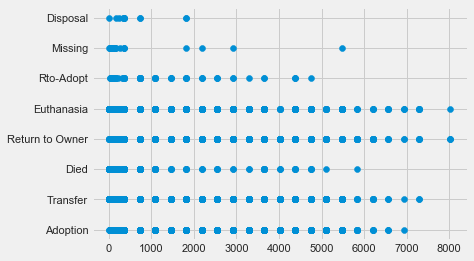

In [525]:
plt.scatter(cats_df['outcome_age_(days)'], cats_df['outcome_type'])

In [526]:
cats_df['outcome_subtype'].value_counts()

Partner           11322
Foster             4213
SCRP               3211
Snr                1577
Suffering          1442
In Kennel           272
In Foster           188
Offsite             110
Rabies Risk          73
Medical              64
At Vet               64
Enroute              20
In Surgery           10
Aggressive            4
Barn                  3
Possible Theft        2
Underage              1
Name: outcome_subtype, dtype: int64

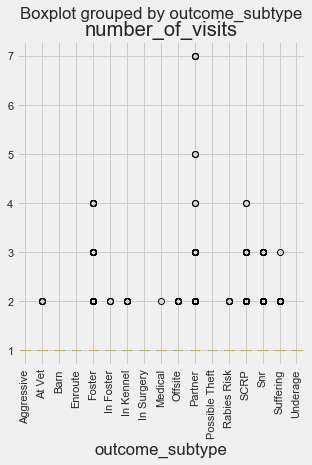

In [528]:
cats_df.boxplot('number_of_visits','outcome_subtype',rot = 90,figsize=(5,6))

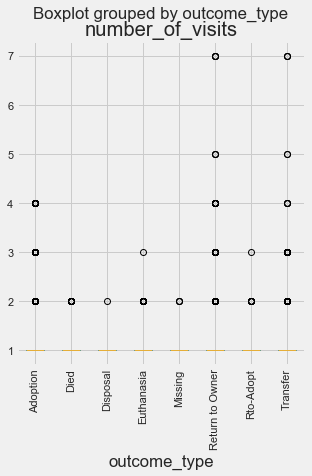

In [529]:
cats_df.boxplot('number_of_visits','outcome_type',rot = 90,figsize=(5,6))

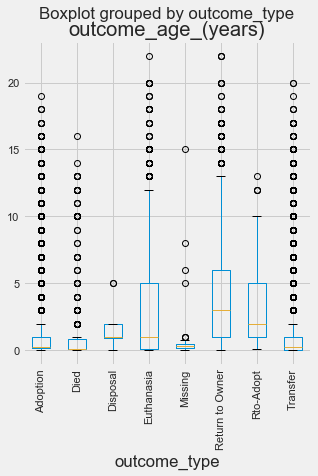

In [530]:
cats_df.boxplot('outcome_age_(years)','outcome_type',rot = 90,figsize=(5,6))

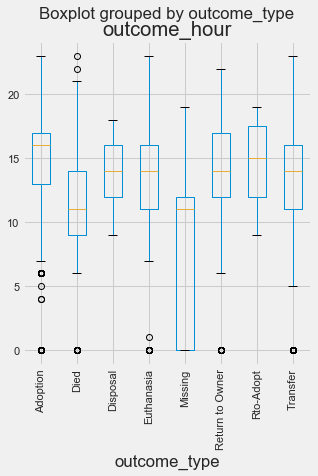

In [531]:
cats_df.boxplot('outcome_hour','outcome_type',rot = 90,figsize=(5,6))

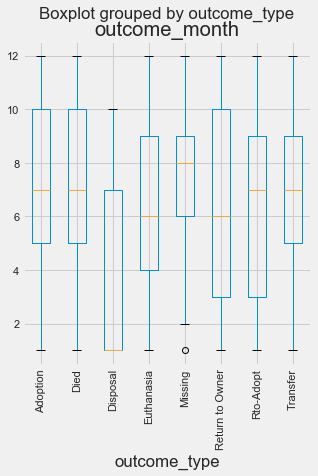

In [532]:
cats_df.boxplot('outcome_month','outcome_type',rot = 90,figsize=(5,6))

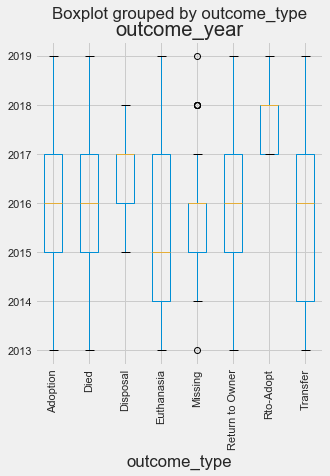

In [533]:
cats_df.boxplot('outcome_year','outcome_type',rot = 90,figsize=(5,6))


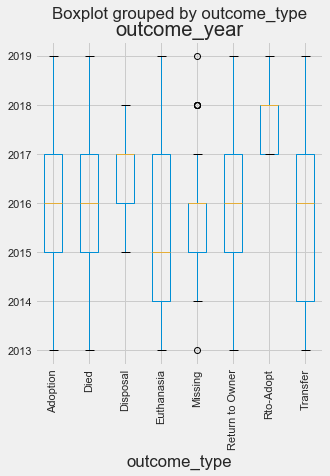

In [534]:
cats_df.boxplot('outcome_year','outcome_type',rot = 90,figsize=(5,6))


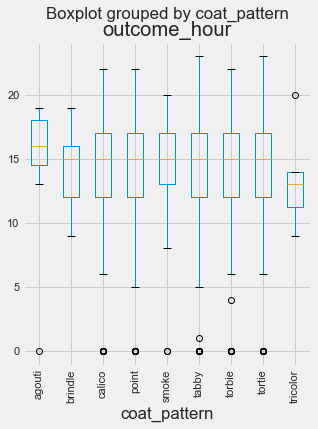

In [535]:
cats_df.boxplot('outcome_hour','coat_pattern',rot = 90,figsize=(5,6))


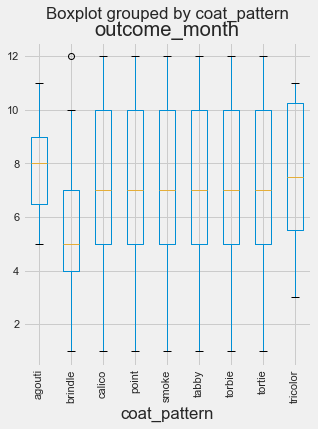

In [536]:
cats_df.boxplot('outcome_month','coat_pattern',rot = 90,figsize=(5,6))


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome Type')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Age Group')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Weekday')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Coat Pattern')

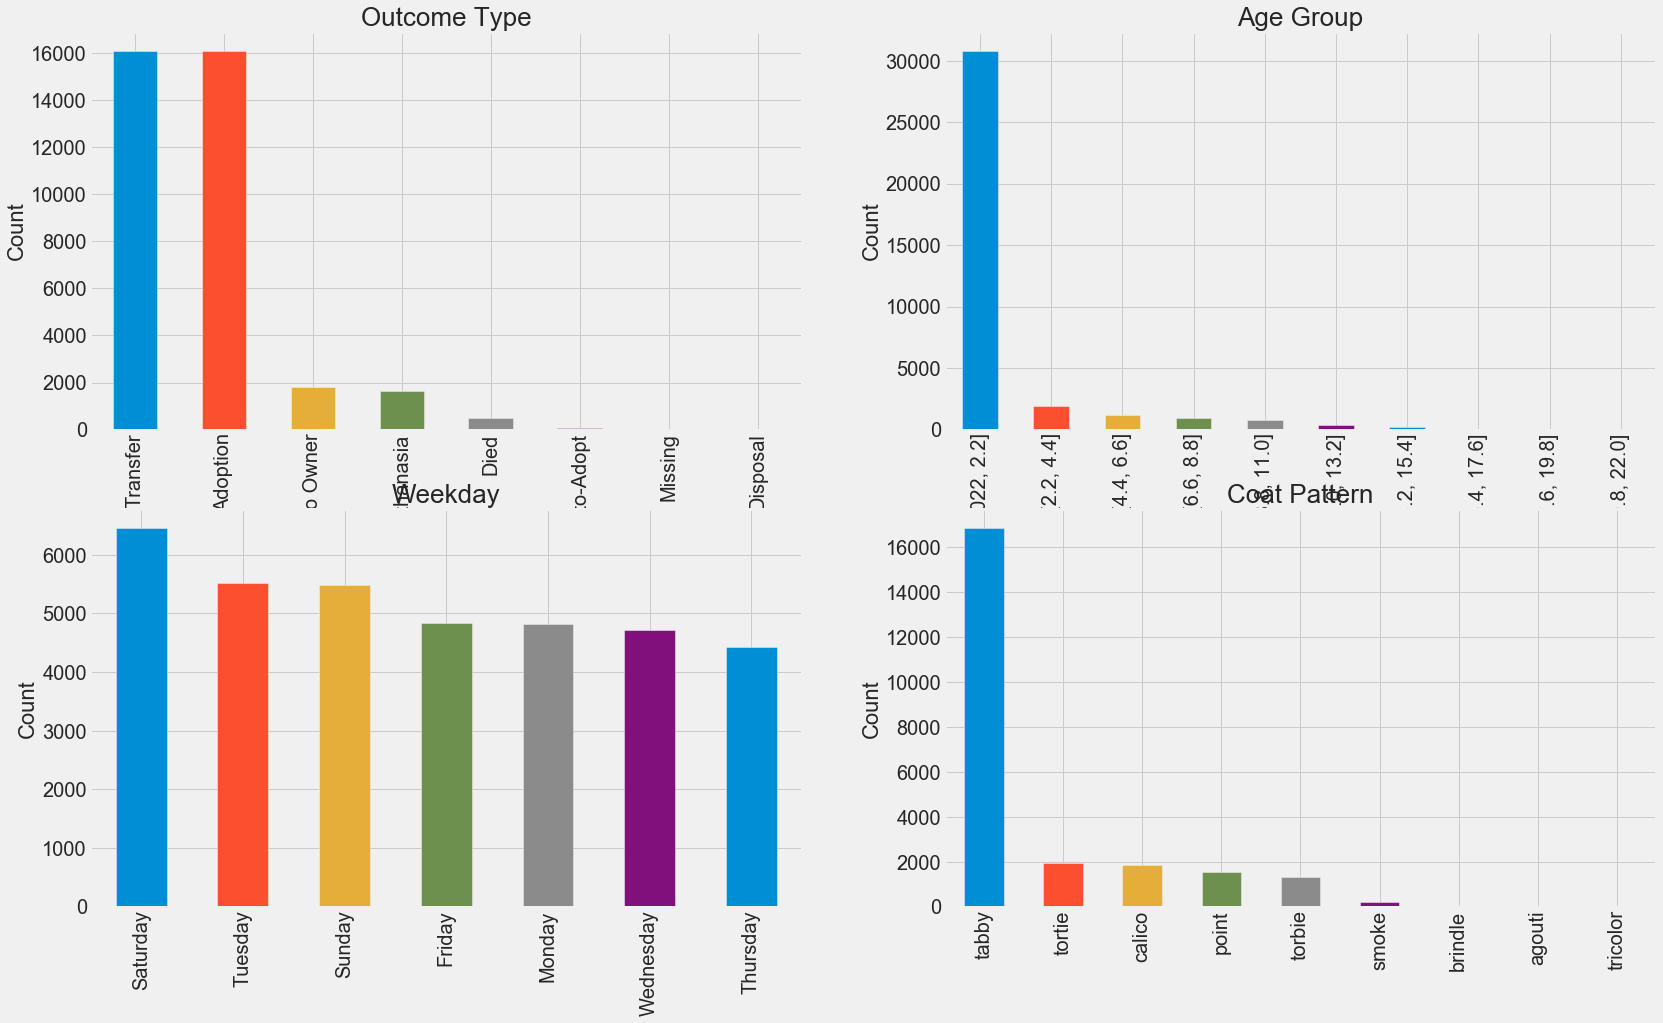

In [537]:
f, ax = plt.subplots(2, 2, figsize=(25, 15))

p1 = cats_df['outcome_type'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Outcome Type', fontsize=26)

p2 = cats_df['age_group'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Age Group', fontsize=26)

p3 = cats_df['outcome_weekday'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,0])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Weekday', fontsize=26)

p4 = cats_df['coat_pattern'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,1])
p4.set_ylabel('Count', fontsize=22)
p4.set_title('Coat Pattern', fontsize=26)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome (Year)')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome (Month)')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome (Hour)')

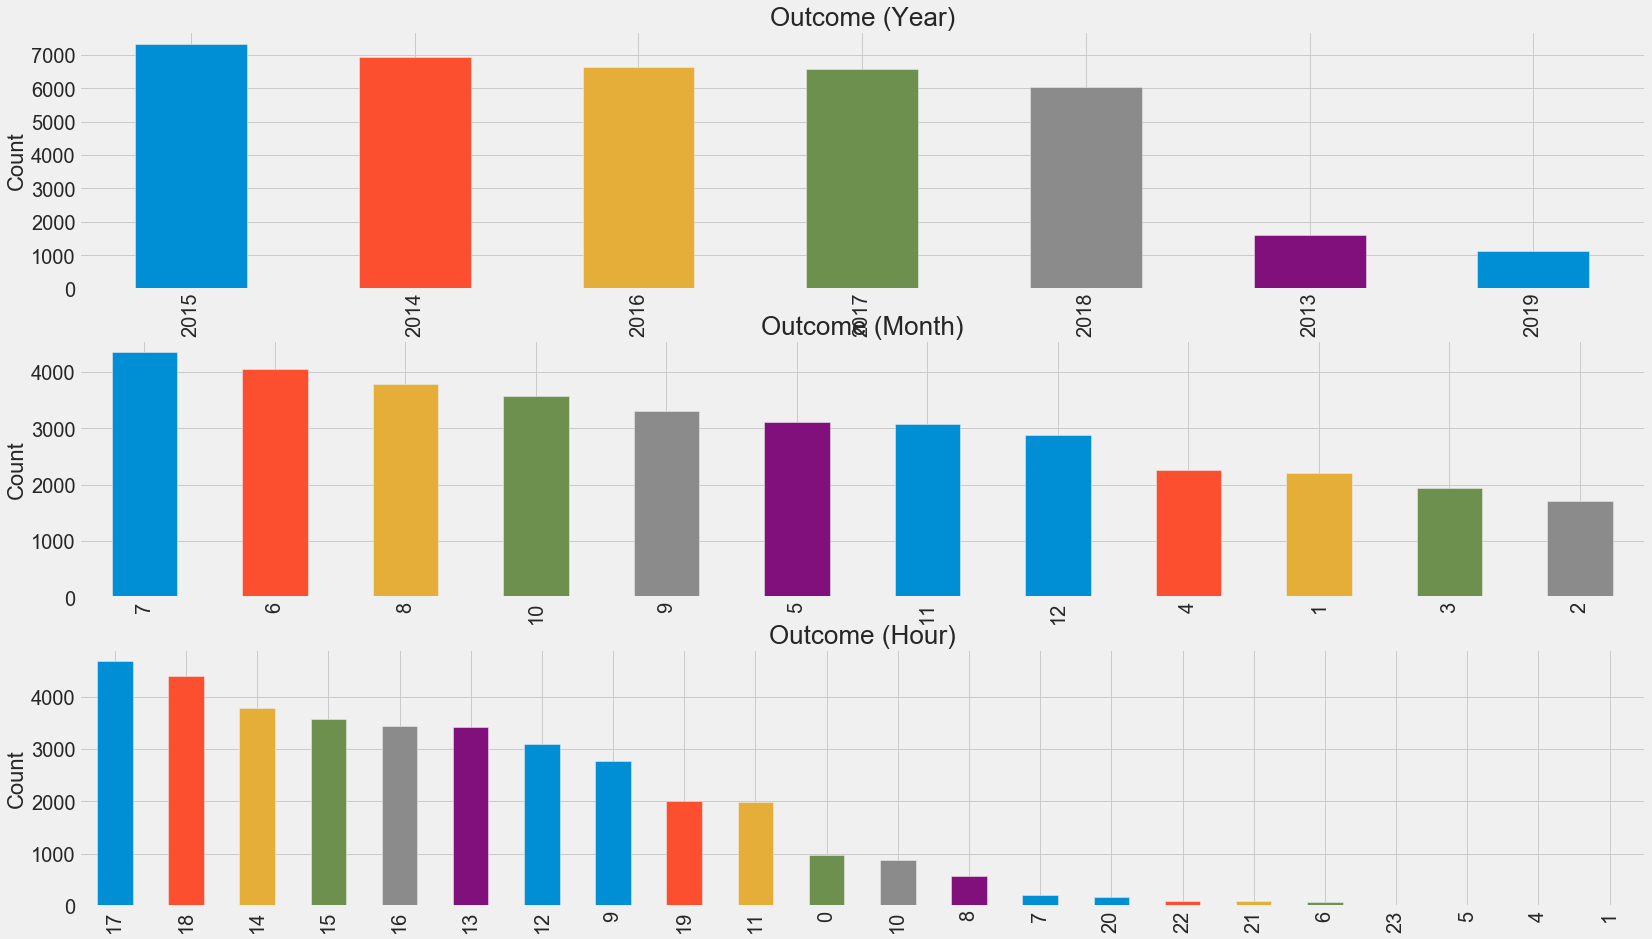

In [538]:
f, ax = plt.subplots(3, 1, figsize=(25, 15))

p1 = cats_df['outcome_year'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Outcome (Year)', fontsize=26)

p2 = cats_df['outcome_month'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Outcome (Month)', fontsize=26)

p3 = cats_df['outcome_hour'].value_counts().plot(kind='bar', fontsize=20, ax=ax[2])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Outcome (Hour)', fontsize=26)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Hourly Outcome')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Hour')

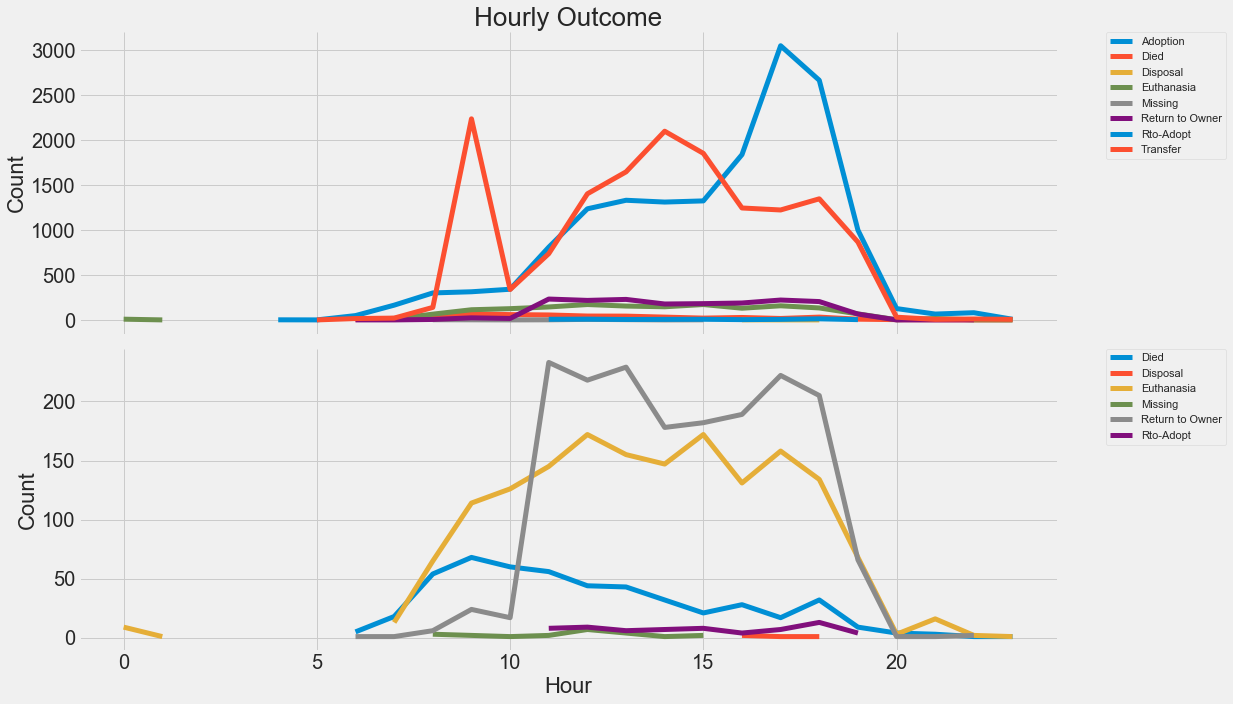

In [539]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

outcomes_not_transferred = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
outcomes_not_transferred = outcomes_not_transferred[~cats_df['outcome_type'].str.contains('Transfer')]

hourly_outcome_not_trans = pd.pivot_table(outcomes_not_transferred, 
                              index=['outcome_hour'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

p1 = hourly_outcome.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Hourly Outcome', fontsize=26)

p2 = hourly_outcome_not_trans.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Hour', fontsize=22)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Monthly Outcome Volume')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Month')

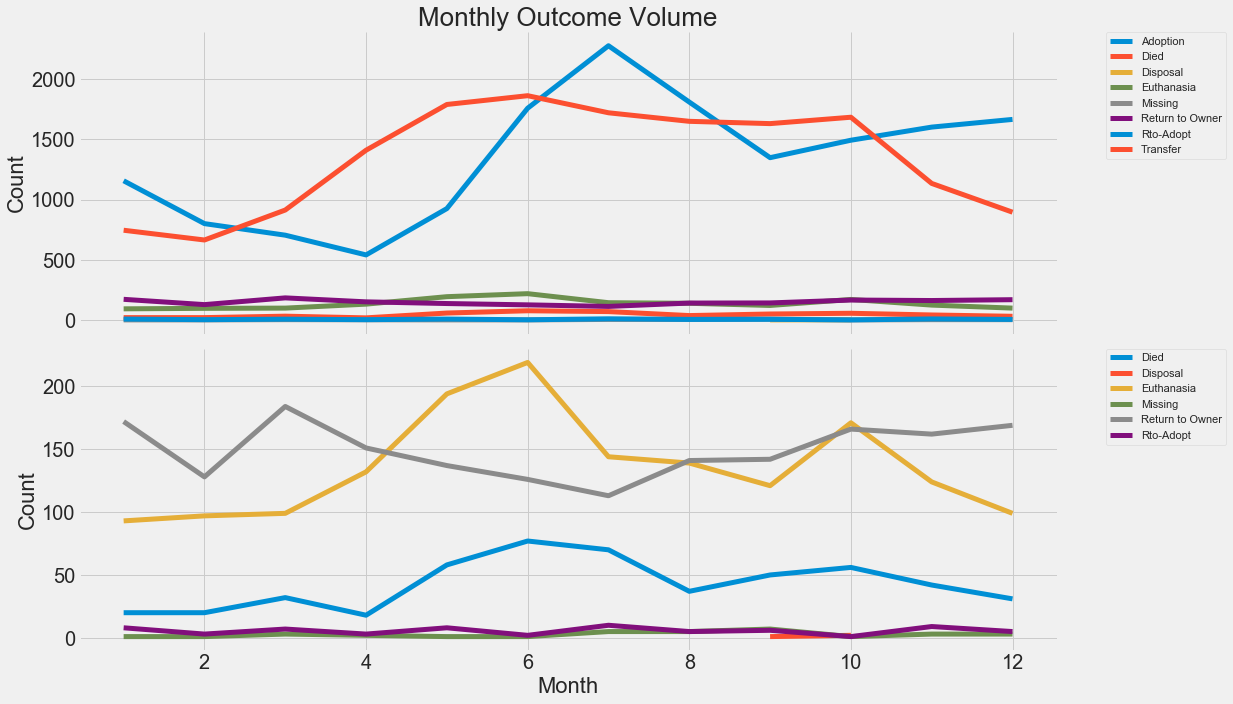

In [540]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_month'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

outcomes_not_transferred = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
outcomes_not_transferred = outcomes_not_transferred[~cats_df['outcome_type'].str.contains('Transfer')]

hourly_outcome_not_trans = pd.pivot_table(outcomes_not_transferred, 
                              index=['outcome_month'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

p1 = hourly_outcome.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Monthly Outcome Volume', fontsize=26)

p2 = hourly_outcome_not_trans.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Month', fontsize=22)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Some Stats

#### Conditional Probabilities

In [541]:
prob_kitten = cats_df.groupby('Kitten').size().div(len(cats_df))
cats_df.groupby(['Kitten', 'outcome_type']).size().div(len(cats_df)).div(prob_kitten)



Kitten  outcome_type   
0       Adoption           0.349334
        Died               0.009259
        Disposal           0.000788
        Euthanasia         0.066583
        Missing            0.000591
        Return to Owner    0.106245
        Rto-Adopt          0.003743
        Transfer           0.463458
1       Adoption           0.512439
        Died               0.017600
        Disposal           0.000048
        Euthanasia         0.029396
        Missing            0.001142
        Return to Owner    0.008229
        Rto-Adopt          0.000476
        Transfer           0.430671
dtype: float64

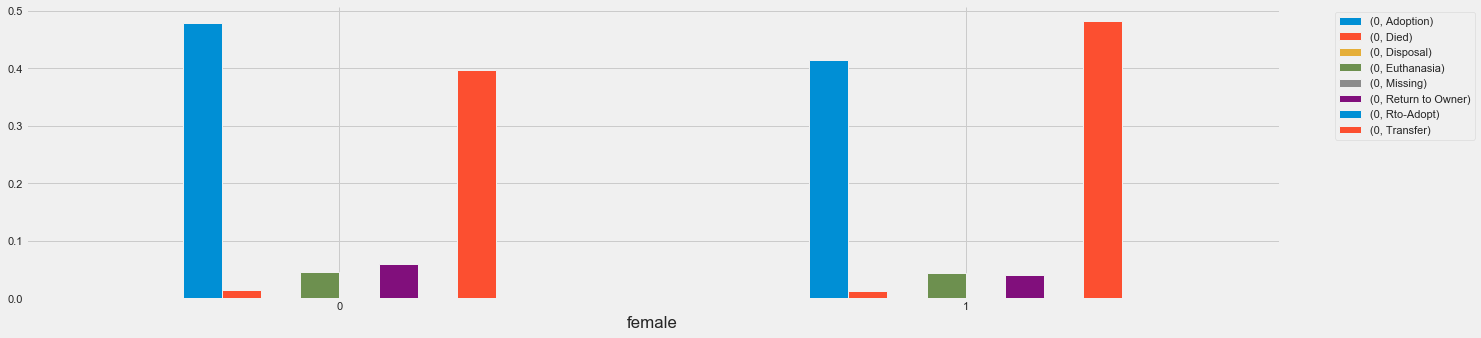

In [567]:
female_probabilities = cats_df.groupby('female').size().div(len(cats_df))
females = cats_df.groupby(['female', 'outcome_type']).size().div(len(cats_df)).div(female_probabilities)
females_df = females.to_frame()
plt = females_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


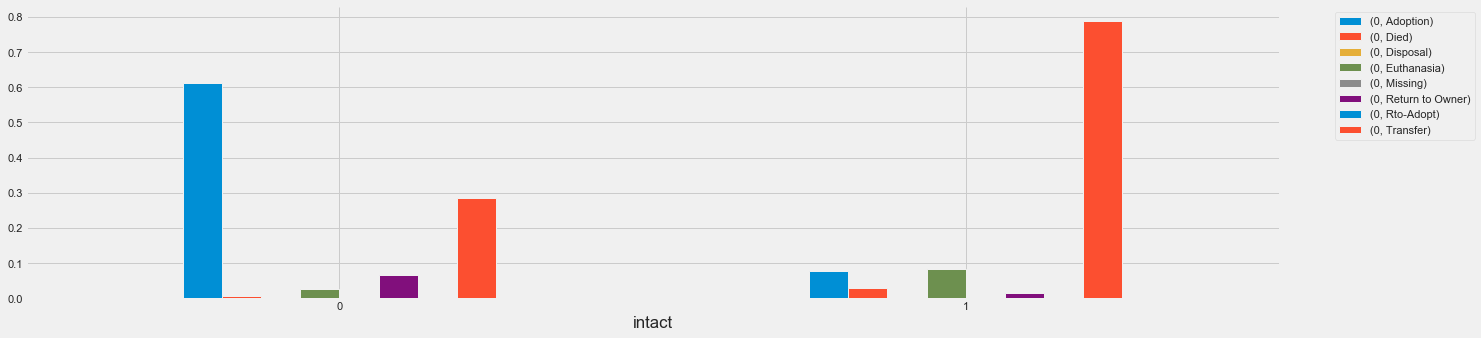

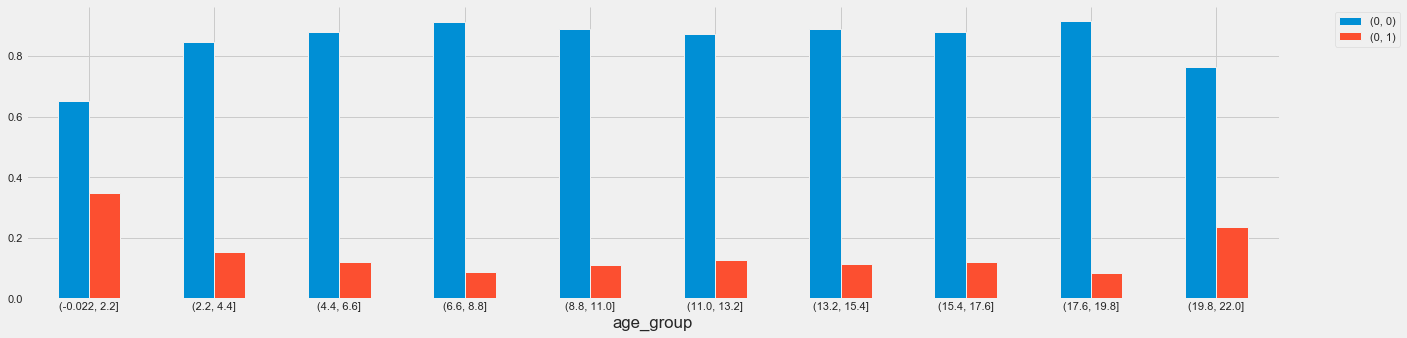

In [589]:
# Intact cats are more prone to dieing vs ones that are spayed/neutuered. Taking this one step further, intact cats
# are more likely to be really young, or very old, so there will likely be some form of correlation between these
# three variables. Something to explore?

intact_probabilities = cats_df.groupby('intact').size().div(len(cats_df))
intact = cats_df.groupby(['intact', 'outcome_type']).size().div(len(cats_df)).div(intact_probabilities)
intact_df = intact.to_frame()
plt = intact_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

age_probabilities = cats_df.groupby('age_group').size().div(len(cats_df))
age = cats_df.groupby(['age_group', 'intact']).size().div(len(cats_df)).div(age_probabilities)
age_df = age.to_frame()
plt = age_df.unstack('intact').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


Text(0.5, 1.0, 'Correlation of Variables')

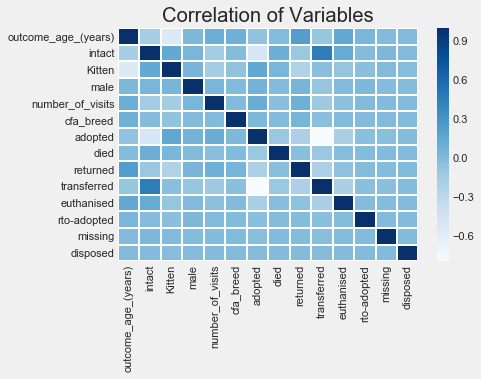

In [647]:
## exploring correlation between age_group and intact and death!
corr_df = pd.DataFrame()
corr_df['outcome_age_(years)'] = cats_df['outcome_age_(years)']
corr_df['intact'] = cats_df['intact']
corr_df['Kitten'] = cats_df['Kitten']
corr_df['male'] = cats_df['male']
corr_df['color'] = cats_df['color']
corr_df['number_of_visits'] = cats_df['number_of_visits']
corr_df['cfa_breed'] = cats_df['cfa_breed']
corr_df['outcome_weekday'] = cats_df['outcome_weekday']
corr_df['coat_pattern'] = cats_df['coat_pattern']
corr_df['adopted'] = cats_df['adopted']
corr_df['died'] = cats_df['died']
corr_df['returned'] = cats_df['returned']
corr_df['transferred'] = cats_df['transferred']
corr_df['euthanised'] = cats_df['euthanised']
corr_df['rto-adopted'] = cats_df['rto-adopted']
corr_df['missing'] = cats_df['missing']
corr_df['disposed'] = cats_df['disposed']
# plot the heatmap
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(corr_df.corr(), cmap="Blues",linewidths=1, ax=ax)
ax.set_title('Correlation of Variables')
plt.show()

### Some interesting  correlation outcomes

1) Intact VS Kitten

2) Number of visits VS age at outcome

3) Dead VS Intact

4) Outcome age VS CFA Breed

5) Transferred VS Intact

6) Adopted VS Kitten

7) Returned VS Age

8) Euthanised VS Age

9) Euthanised VS Intact

### Contingency Table and Chi^2

In [698]:
crosstab = pd.crosstab(cats_df['died'], cats_df['intact'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

319.4734915422913

1.8861944907674837e-71

In [693]:
crosstab = pd.crosstab(cats_df['intact'], cats_df['Kitten'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

716.4003100774911

8.117219914101153e-158

In [694]:
crosstab = pd.crosstab(cats_df['adopted'], cats_df['Kitten'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

951.1004323891423

7.647802810417253e-209

In [699]:
crosstab = pd.crosstab(cats_df['Kitten'], cats_df['outcome_age_(years)'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

36252.0

0.0

In [700]:
crosstab = pd.crosstab(cats_df['number_of_visits'], cats_df['outcome_age_(years)'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

1563.096864142085

4.652387787609287e-203

In [701]:
crosstab = pd.crosstab(cats_df['returned'], cats_df['outcome_age_(years)'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

2888.0836598133724

0.0

In [703]:
crosstab = pd.crosstab(cats_df['intact'], cats_df['transferred'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

8037.57650680899

0.0

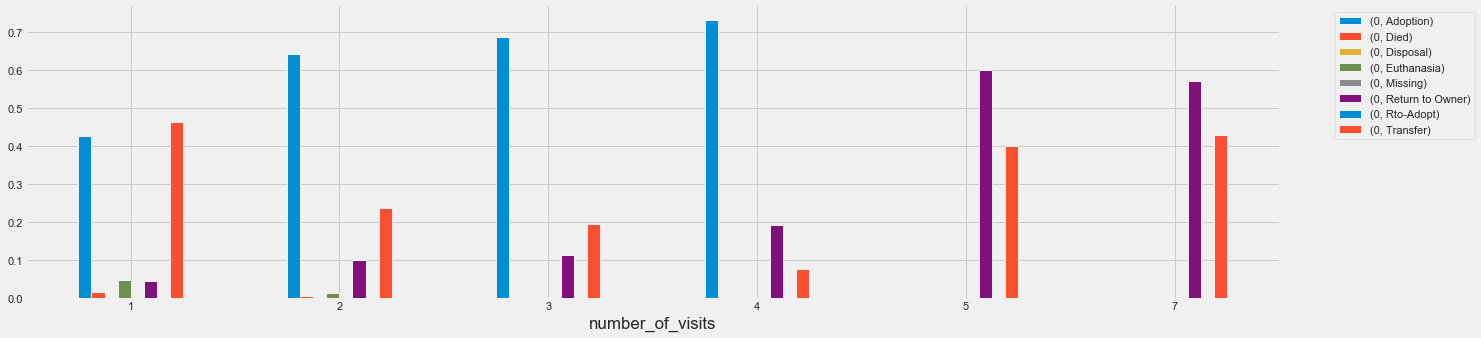

In [566]:
num_of_visits_probabilities = cats_df.groupby('number_of_visits').size().div(len(cats_df))
number_of_visits = cats_df.groupby(['number_of_visits', 'outcome_type']).size().div(len(cats_df)).div(num_of_visits_probabilities)
number_of_visits_df = number_of_visits.to_frame()
plt = number_of_visits_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


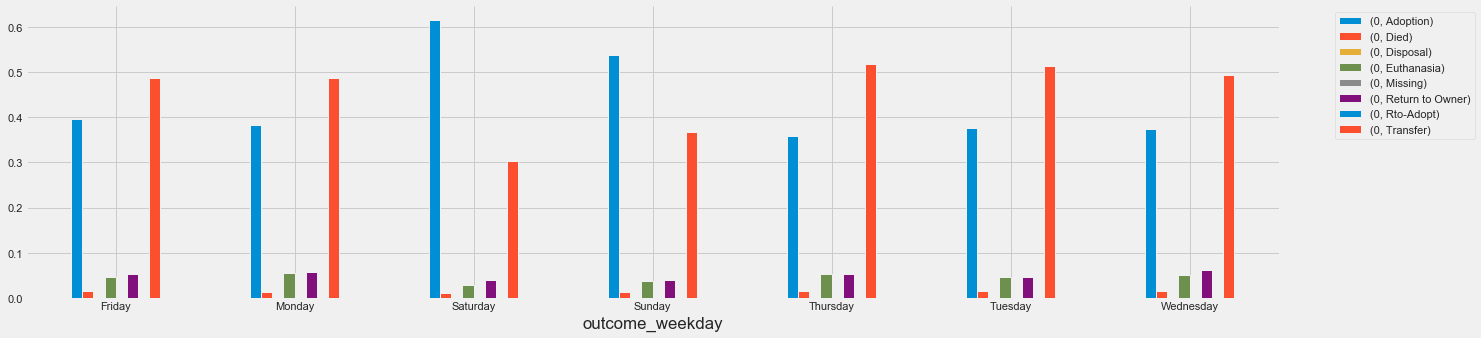

In [568]:
weekday_probabilities = cats_df.groupby('outcome_weekday').size().div(len(cats_df))
weekdays = cats_df.groupby(['outcome_weekday', 'outcome_type']).size().div(len(cats_df)).div(weekday_probabilities)
weekdays_df = weekdays.to_frame()
plt = weekdays_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


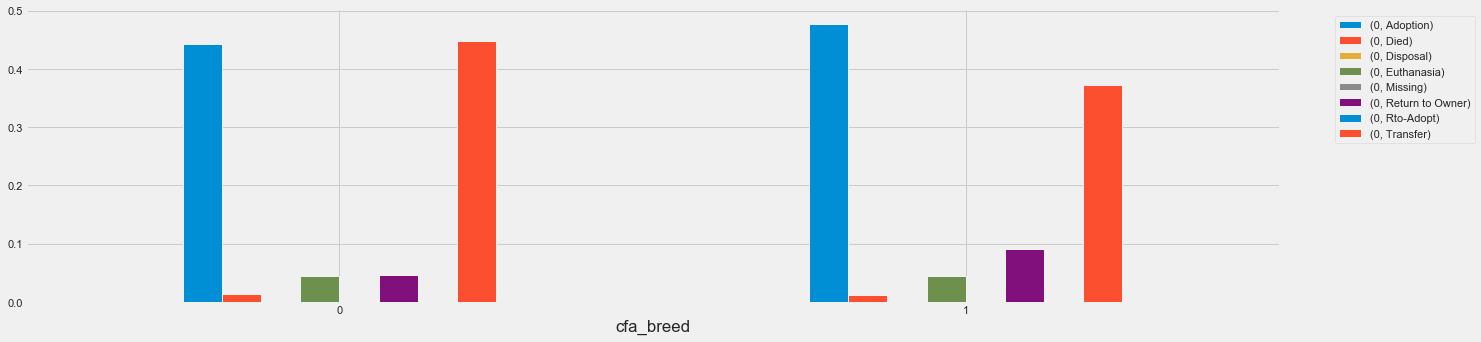

In [571]:
cfa_breed_probabilities = cats_df.groupby('cfa_breed').size().div(len(cats_df))
cfa_breed = cats_df.groupby(['cfa_breed', 'outcome_type']).size().div(len(cats_df)).div(cfa_breed_probabilities)
cfa_breed_df = cfa_breed.to_frame()
plt = cfa_breed_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


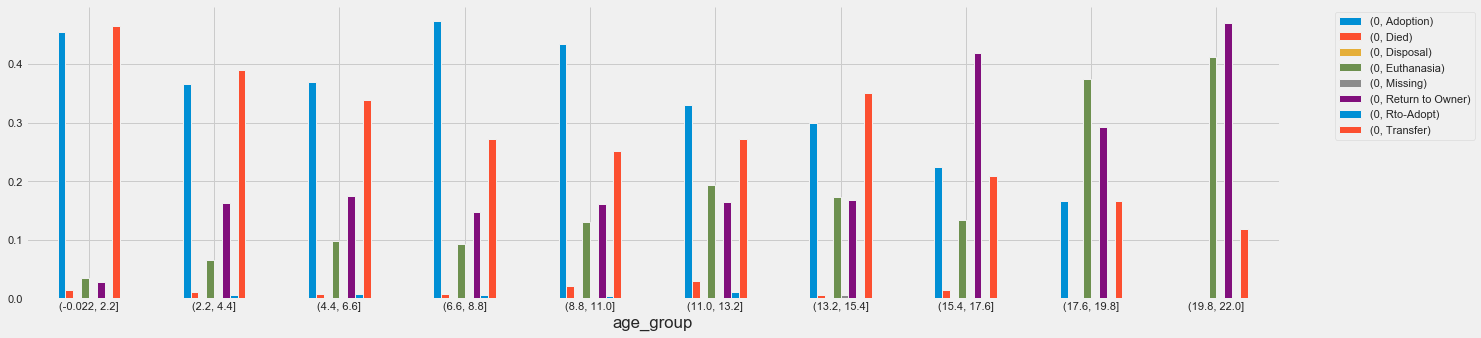

In [572]:
age_group_probabilities = cats_df.groupby('age_group').size().div(len(cats_df))
age_group = cats_df.groupby(['age_group', 'outcome_type']).size().div(len(cats_df)).div(age_group_probabilities)
age_group_df = age_group.to_frame()
plt = age_group_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


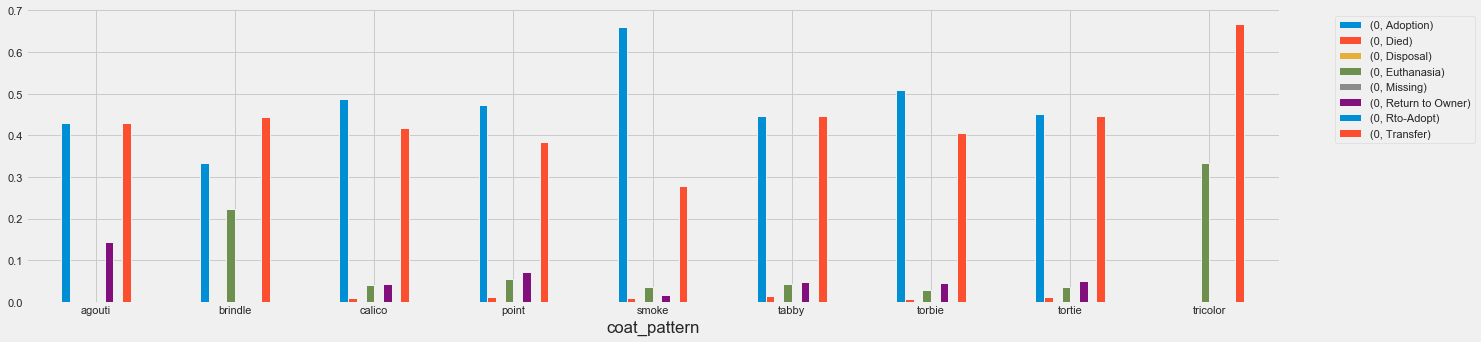

In [573]:
coat_pattern_probabilities = cats_df.groupby('coat_pattern').size().div(len(cats_df))
coat_pattern = cats_df.groupby(['coat_pattern', 'outcome_type']).size().div(len(cats_df)).div(coat_pattern_probabilities)
coat_pattern_df = coat_pattern.to_frame()
plt = coat_pattern_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


In [ ]:
___________________________________________________________________________________________

In [ ]:
### lets try some poison

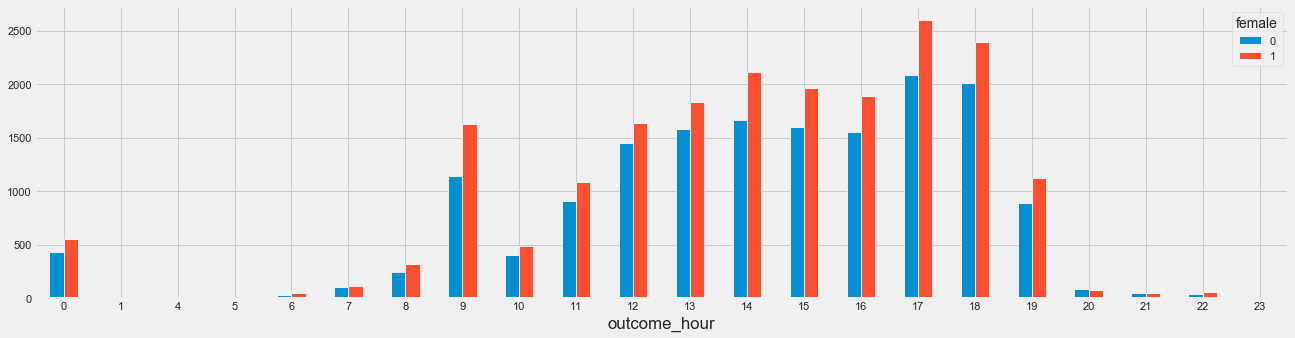

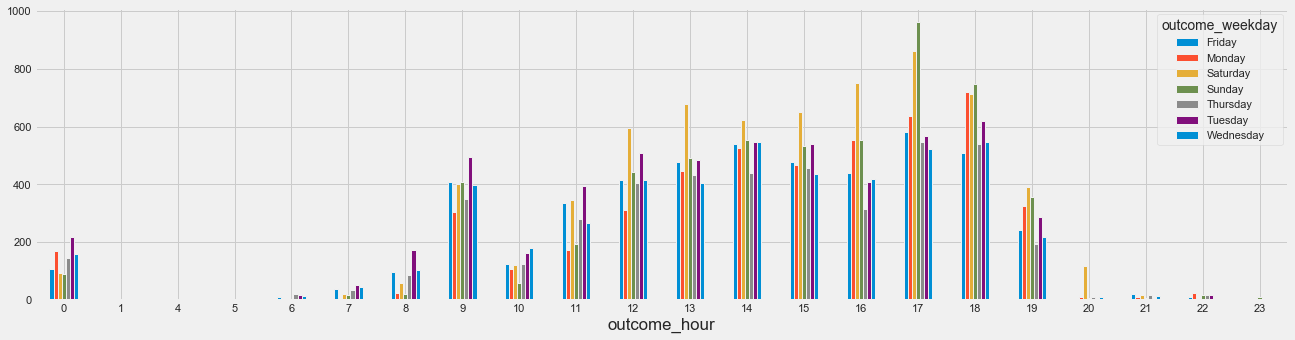

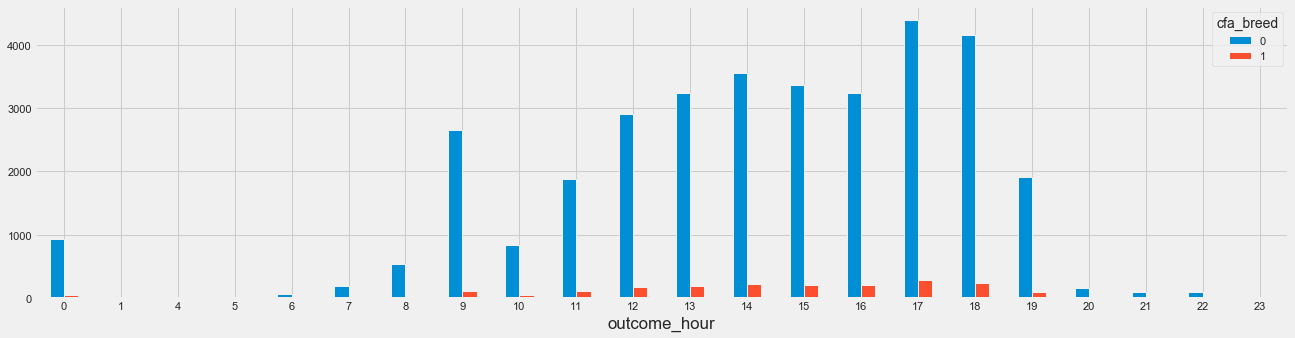

In [582]:
hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['female'], 
                              values='count', aggfunc=np.sum)

hourly_outcome.plot.bar(rot=0, linewidth=1, figsize=(20, 5))

outcome_weekday = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['outcome_weekday'], 
                              values='count', aggfunc=np.sum)

outcome_weekday.plot.bar(rot=0, linewidth=1, figsize=(20, 5))

cfa_breed = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['cfa_breed'], 
                              values='count', aggfunc=np.sum)

cfa_breed.plot.bar(rot=0, linewidth=1, figsize=(20, 5))

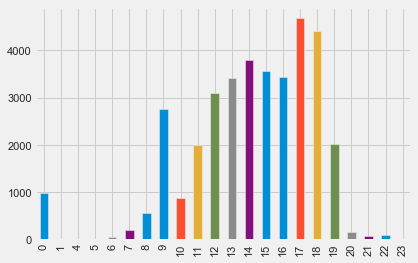

In [659]:
cats_df["outcome_hour"].value_counts().sort_index().plot(kind='bar')

In [ ]:
# _____________________________________________________________________________________________________

In [214]:
### Multinomial Regression
# want to create the following:
# X_TRAIN = [[outcome year, outcome_month, outcome_hour, outcome_age_(years), number_of_visits], ...]
# y_TRAIN = [outcome_type ...]

without_adoption_df = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
without_adoption_df = without_adoption_df[~cats_df['outcome_type'].str.contains('Transfer')]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [215]:
X_TRAIN = cats_df[['female', 'spayed_or_neutered', 'Kitten', 'outcome_hour', 'outcome_age_(years)', 'number_of_visits']].values.tolist()

In [216]:
Y_TRAIN, ynames = pd.factorize(cats_df['outcome_subtype'])

In [217]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_TRAIN, Y_TRAIN, test_size=0.2)

In [218]:
X_test

[[0.0, 1.0, 1.0, 20.0, 0.1643835616438356, 1.0],
 [1.0, 1.0, 1.0, 7.0, 0.410958904109589, 1.0],
 [1.0, 0.0, 0.0, 10.0, 2.0, 1.0],
 [0.0, 1.0, 1.0, 18.0, 0.1643835616438356, 1.0],
 [0.0, 1.0, 1.0, 11.0, 0.1643835616438356, 1.0],
 [1.0, 0.0, 0.0, 9.0, 0.821917808219178, 1.0],
 [1.0, 1.0, 1.0, 18.0, 0.1643835616438356, 1.0],
 [1.0, 1.0, 0.0, 0.0, 0.4931506849315068, 1.0],
 [0.0, 1.0, 0.0, 12.0, 3.0, 1.0],
 [1.0, 1.0, 0.0, 9.0, 1.0, 1.0],
 [1.0, 1.0, 0.0, 13.0, 1.0, 1.0],
 [1.0, 0.0, 1.0, 14.0, 0.1643835616438356, 1.0],
 [1.0, 1.0, 0.0, 13.0, 5.0, 1.0],
 [1.0, 0.0, 1.0, 17.0, 0.1643835616438356, 1.0],
 [1.0, 0.0, 0.0, 18.0, 1.0, 1.0],
 [1.0, 1.0, 0.0, 17.0, 4.0, 1.0],
 [0.0, 1.0, 1.0, 12.0, 0.3287671232876712, 1.0],
 [1.0, 0.0, 1.0, 9.0, 0.410958904109589, 1.0],
 [1.0, 1.0, 0.0, 18.0, 2.0, 1.0],
 [0.0, 0.0, 1.0, 8.0, 0.07671232876712329, 1.0],
 [1.0, 0.0, 1.0, 18.0, 0.0821917808219178, 1.0],
 [0.0, 1.0, 1.0, 12.0, 0.1643835616438356, 1.0],
 [1.0, 0.0, 0.0, 18.0, 7.0, 1.0],
 [1.0, 1.0, 0.0,

In [219]:
y_test[0:100]

array([ 3,  3,  0, -1, -1, 14, -1, -1, -1, 14,  0,  0, -1,  0,  2,  4, -1,
       14, -1,  6, -1,  3,  4, 14,  3, 14, -1,  0, -1,  0,  3,  0, -1, -1,
       -1,  0,  3, 14, 14,  3,  0,  0, 14, -1,  3,  0, 14,  0,  3, -1, -1,
        0,  6,  4,  0, -1, -1, -1, -1,  0,  0, -1,  0,  4,  0,  0, -1,  0,
       -1, -1,  4, -1, -1,  0, -1, -1, -1,  2,  0,  4,  0,  0,  0, -1,  0,
       -1,  0, -1,  0,  0, -1, -1, -1,  3,  3,  0, -1,  0,  0, 14])

In [220]:
len(X_test)

7251

In [221]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)

In [222]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [223]:
y_predicted = model.predict(X_test)
y_predicted.tolist()[0:20]
y_test[0:20]


[-1, 0, 14, -1, 3, 14, -1, 14, -1, 14, -1, 0, -1, 0, 2, -1, 3, 0, -1, 0]

array([ 3,  3,  0, -1, -1, 14, -1, -1, -1, 14,  0,  0, -1,  0,  2,  4, -1,
       14, -1,  6])

In [224]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predicted)
cm

array([[2340,  252,    0,   10,   88,    3,    0,    0,    0,    0,    0,
           0,    0,   25],
       [ 817, 1275,    0,   14,   59,    6,    0,    0,    0,    0,    0,
           0,    0,  144],
       [   9,   35,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    6],
       [  85,   60,    0,   66,    1,    0,    0,    0,    0,    0,    0,
           0,    0,   74],
       [ 544,  163,    0,    0,  127,    0,    0,    0,    0,    0,    0,
           0,    0,   28],
       [  92,  135,    0,    9,    2,   13,    0,    0,    0,    0,    0,
           0,    0,   48],
       [   7,    5,    0,    0,    0,    1,    0,    0,    0,    0,    0,
           0,    0,    1],
       [   3,   35,    0,    0,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    1],
       [   3,    9,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    5],
       [   3,    5,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    

<Figure size 720x504 with 0 Axes>

Text(0.5, 9.779999999999973, 'Predicted')

Text(32.1, 0.5, 'Truth')

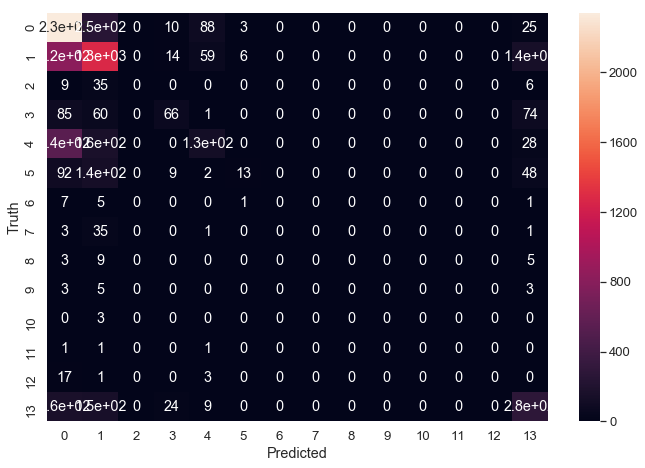

In [225]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [226]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predicted))

Accuracy: 0.564887601710109


In [227]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 1080x1080 with 0 Axes>

Normalized confusion matrix


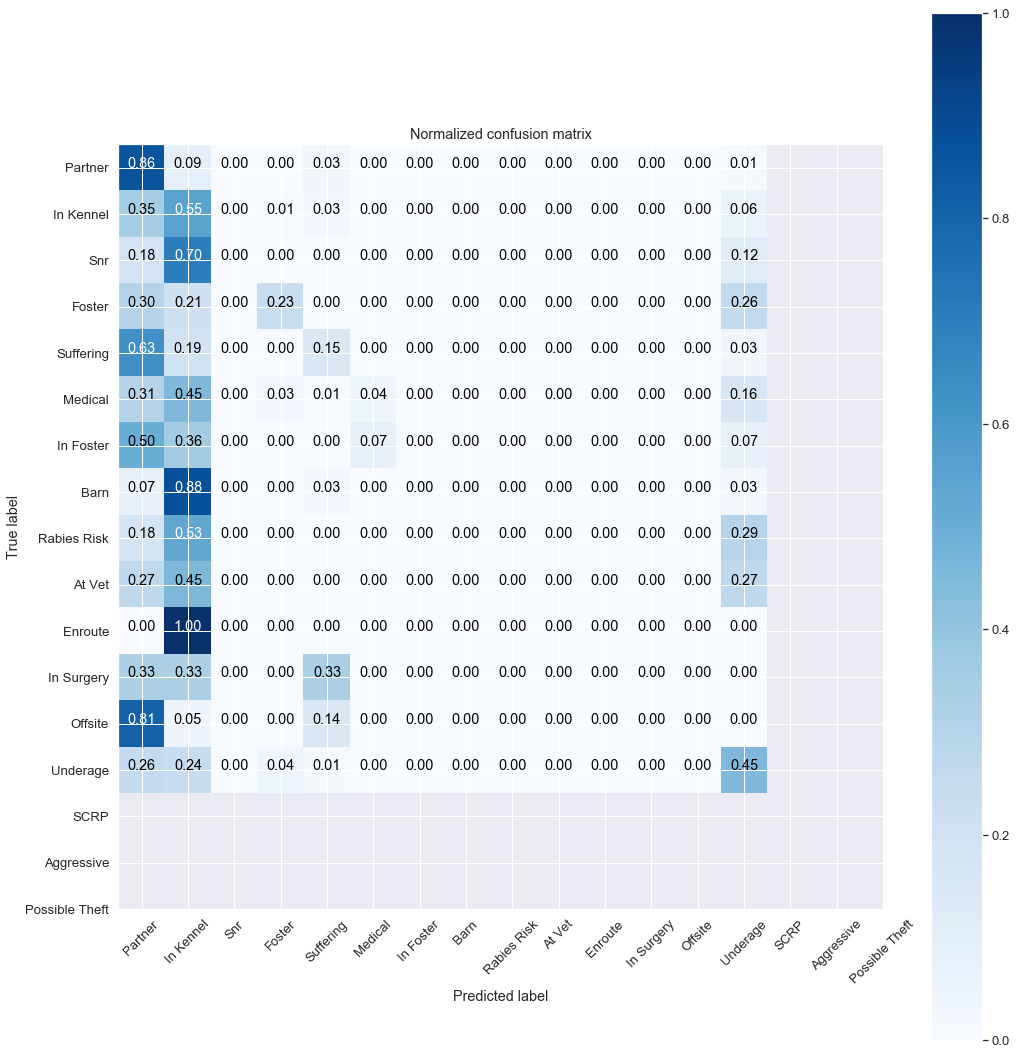

In [232]:
sns.set(font_scale=1.2)

plt.figure(figsize=(15, 15))
plot_confusion_matrix(cm, classes=ynames, normalize=True, title='Normalized confusion matrix')

plt.show()


In [229]:
# it looks like transfer, Rto-Adopt need better tuning....